## INF8953DE (Fall 2021) : Reinforcement Learning - Assignment 1
## Amine EL AMERI - Matricule: 2164634

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 1 Bandit Problem

##### Q1

In [ ]:
class Bandit():

  def __init__(self):
    self.numberOfArms = 10
    self.mean = 0
    self.variance = 1
    self.stdDeviation = np.sqrt(self.variance)
    self.q_star = [np.random.normal(self.mean, self.stdDeviation) for i in range(10)] #action values
    self.q_star_a_star = max(self.q_star) # best action value
    self.Q = [0]*10 # estimates of action values
    self.nTimes = [0]*10 # number of times each action is selected

    self.H_t = [0]*10 # preferences of the actions
    self.alpha_GB = 0



  def pull(self, action):
    R = np.random.normal(self.q_star[action-1], self.stdDeviation) # reward
    self.nTimes[action-1] += 1
    self.Q[action-1] = self.Q[action-1] + (R-self.Q[action-1])/self.nTimes[action-1]
    return R

In [ ]:
banditQ1 = Bandit()
banditQ1.pull(7)

-0.23639739164512186

##### Q2

In [ ]:
def epsilon_greedy(self, epsilon):
  randNumber = np.random.uniform(0,1) 
  if randNumber >= epsilon:
    knownRewards = [i for i in self.Q if i is not None]
    if len(knownRewards) == 0: # this is our first pull
      return self.pull(np.random.randint(1,10))
    else:
      greedyAction = self.Q.index(max(knownRewards)) + 1
      return self.pull(greedyAction)
  else:
    return self.pull(np.random.randint(1,10))


Bandit.epsilon_greedy = epsilon_greedy

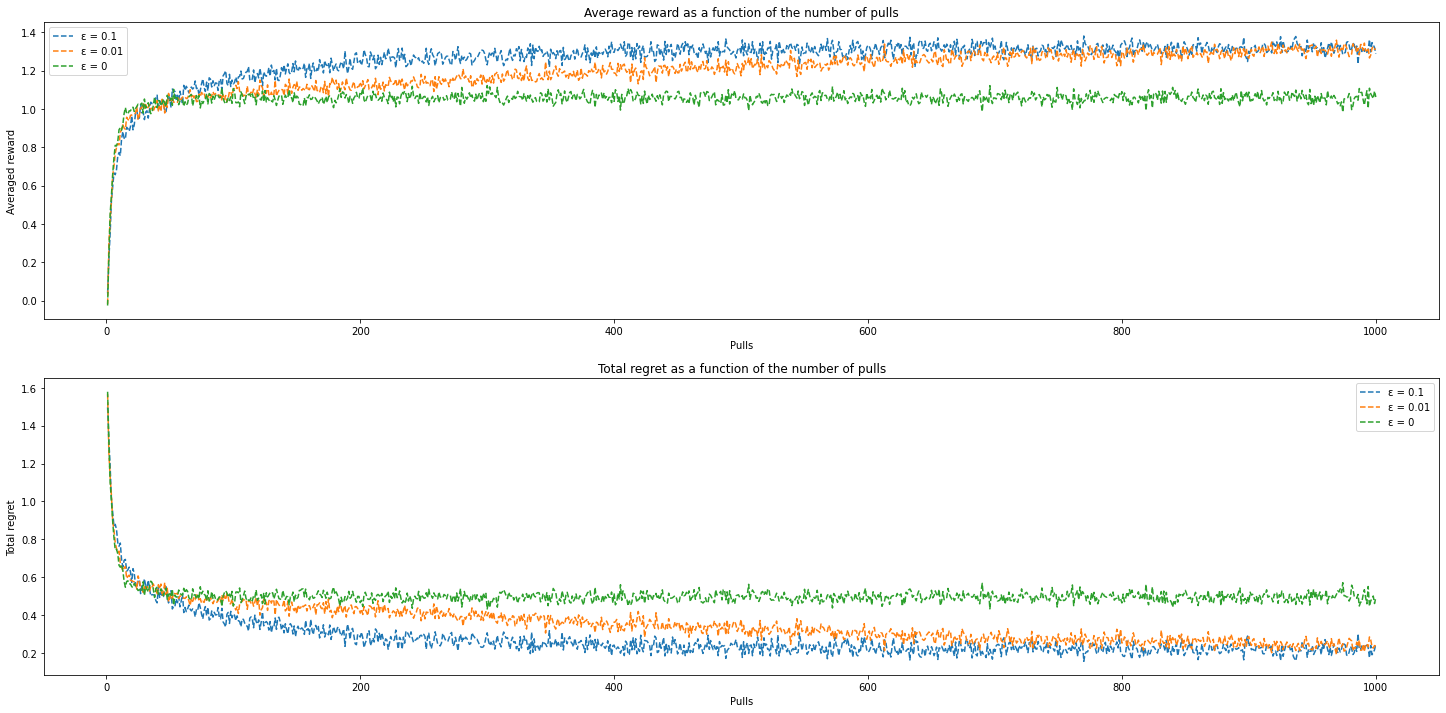

In [ ]:
def Q2Plots(nRuns, nPulls, epsilons):

  fig, axs = plt.subplots(2)

  for eps in epsilons:
    bandits = [None]*nRuns # list of bandit instances
    x = []
    y_reward = [] 
    y_regret = []
    for pull in range(nPulls):
      avgReward = 0
      avgRegret = 0
      for run in range(nRuns): # each run (all the pulls associated) is done by 1 bandit instance
        if bandits[run] == None:
          bandits[run] = Bandit()
          reward = bandits[run].epsilon_greedy(eps)
          avgReward += reward # average reward for a pull across runs
          avgRegret += bandits[run].q_star_a_star - reward # average regret for a pull across runs 
        else:
          reward = bandits[run].epsilon_greedy(eps)
          avgReward += reward
          avgRegret += bandits[run].q_star_a_star - reward
        
      avgReward /= nRuns
      avgRegret /= nRuns
      x.append(pull+1)
      y_reward.append(avgReward)
      y_regret.append(avgRegret)
    
    
    axs[0].plot(x, y_reward, ls='--')
    axs[1].plot(x, y_regret, ls='--')

  axs[0].set_xlabel("Pulls")
  axs[0].set_ylabel("Averaged reward")
  axs[0].set_title("Average reward as a function of the number of pulls")
  axs[0].legend(["\u03B5 = 0.1", "\u03B5 = 0.01", "\u03B5 = 0"])

  axs[1].set_xlabel("Pulls")
  axs[1].set_ylabel("Total regret")
  axs[1].set_title("Total regret as a function of the number of pulls")
  axs[1].legend(["\u03B5 = 0.1", "\u03B5 = 0.01", "\u03B5 = 0"])



plt.rcParams['figure.figsize'] = [25, 12]
Q2Plots(2000, 1000, [0.1, 0.01, 0])

I expected the epsilon greedy method with the biggest ϵ in {0, 0.01, 0.1} to be the best, because it does more exploration and thus has more chance to discover the action with the biggest reward quickly and then exploit it. This is indeed the case here when looking at the plots (eps=0.1 better than eps=0.01 better than eps=0).

##### Q3

The epsilon greedy method with ϵ = 0.9 is not a good strategy because even if it will discover the best action quickly (because of doing exploration 90% of the time), exploiting this action only 10% of the time is not enough. This method will always be taking a big number of random (thus not optimal) decisions.

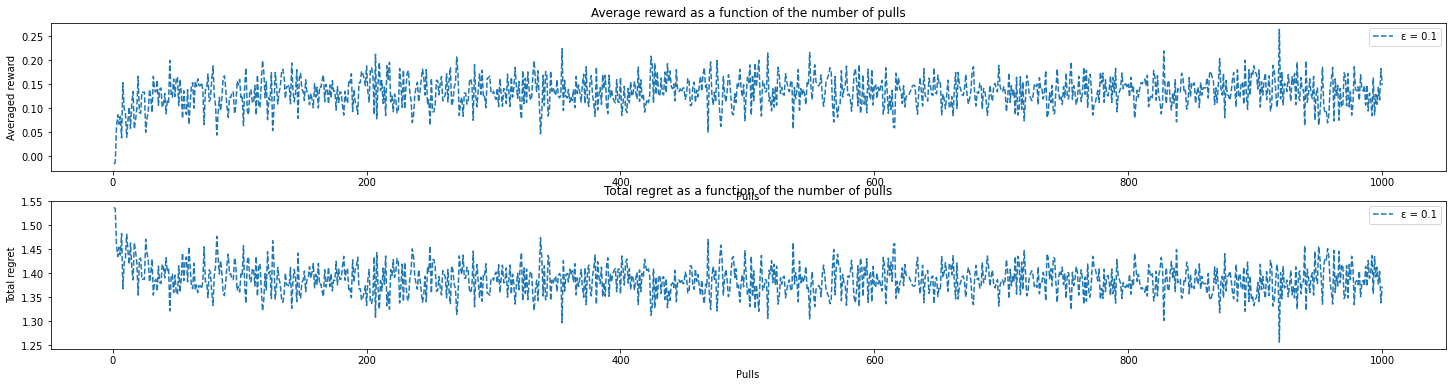

In [ ]:
plt.rcParams['figure.figsize'] = [25, 6]
Q2Plots(2000, 1000, [0.9])

Indeed, even after 900+ pulls, the plot shows that epsilon greedy with 0.9 still takes random and not optimal actions. The average reward is not comparable to what the same algorithm with eps = 0.1 or 0.01 could win.

##### Q4

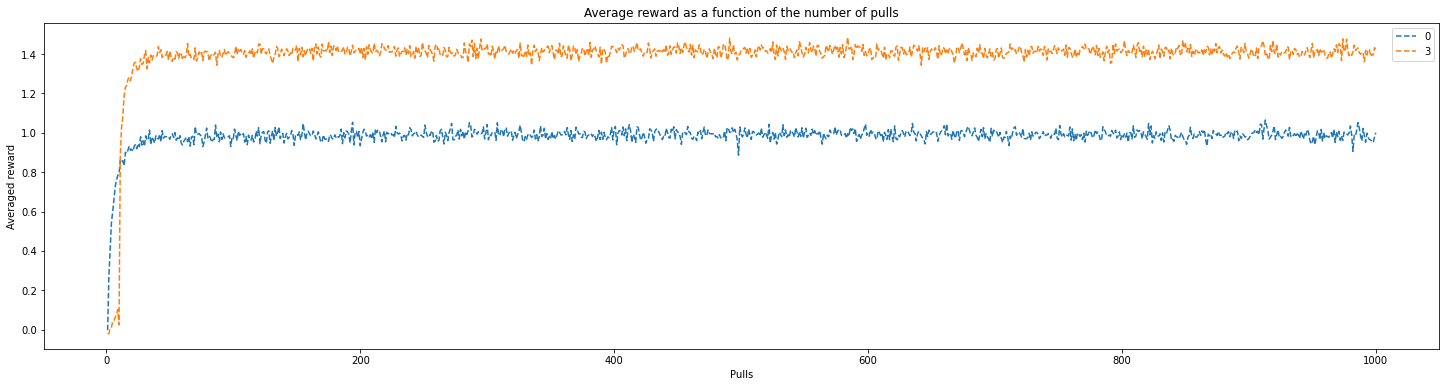

In [ ]:
def optimisticInitialValue_withPlot(nRuns, nPulls, initValues):

  fig, ax = plt.subplots()

  for initValue in initValues:
    bandits = [None]*nRuns # list of bandit instances
    x = []
    y_reward = [] 
    for pull in range(nPulls):
      avgReward = 0
      for run in range(nRuns):  # each run (all the pulls associated) is done by 1 bandit instance

        if bandits[run] == None:
          bandits[run] = Bandit()
          bandits[run].Q = [initValue]*10  # initializing the new bandit instance with optimistic values

        action = np.argmax(bandits[run].Q) + 1
        reward = bandits[run].pull(action)
        avgReward += reward # average reward for a pull across runs

      avgReward /= nRuns
      x.append(pull+1)
      y_reward.append(avgReward)
    
    
    ax.plot(x, y_reward, ls='--', label = initValue)

  ax.set_xlabel("Pulls")
  ax.set_ylabel("Averaged reward")
  ax.set_title("Average reward as a function of the number of pulls")
  ax.legend(loc='best')




plt.rcParams['figure.figsize'] = [25, 6]
optimisticInitialValue_withPlot(2000, 1000, [0, 3])

I expected the algorithm with optimistic setting to have a better average reward because the optimistic initial values makes the algorithm explore more before starting the exploitation. This is indeed what we see in the plots.

##### Q5

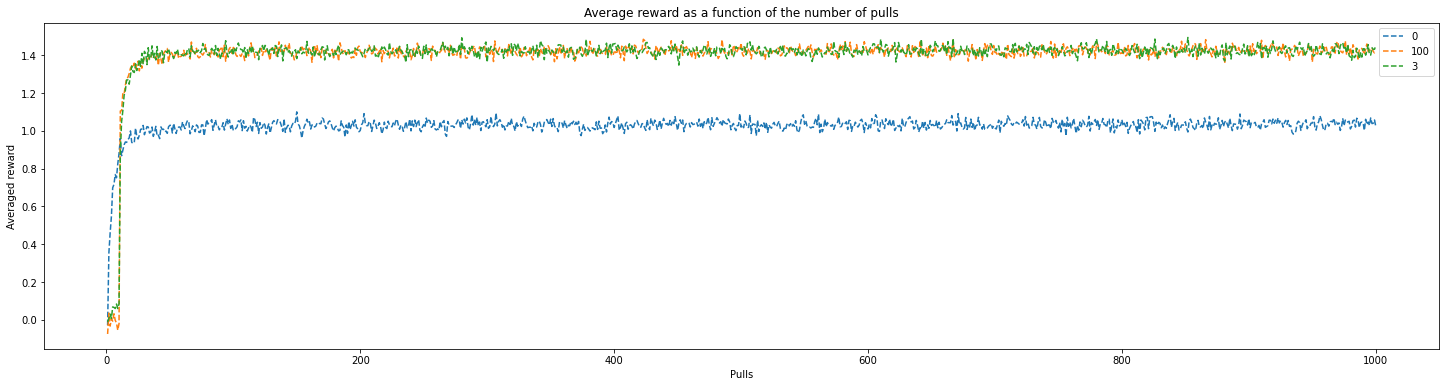

In [ ]:
optimisticInitialValue_withPlot(2000, 1000, [0, 100, 3])

I expected the plots of the two settings Q1(a) = 3 and Q1(a) = 100 to be different at the beginning (Q1(a) = 100 will explore for more time) but to converge after a certain number of pulls to the same average award, since they will both have a good estimate of the action values, and thus will exploit the same action. And this is what we see in the plots.

##### Q6

In [ ]:
def UCB(self, c):
  if 0 in self.nTimes: # if an action have Nt(a) = 0, we choose it
    return self.pull(self.nTimes.index(0) + 1)
  else:
    UCBAction = np.argmax( np.array(self.Q) + c*np.sqrt(np.log(sum(self.nTimes))) / np.sqrt(np.array(self.nTimes)) ) + 1
    return self.pull(UCBAction)

Bandit.UCB = UCB

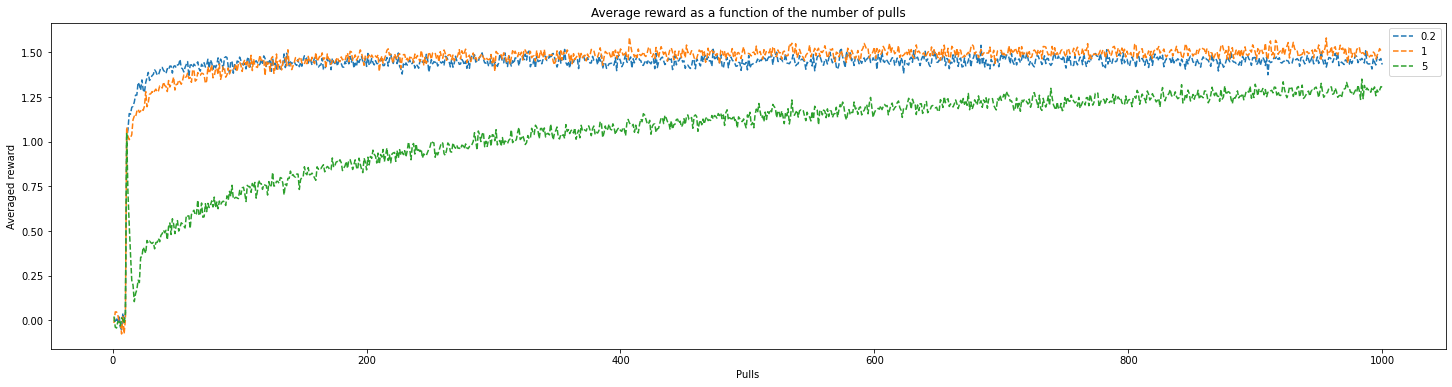

In [ ]:
def UCB_Plots(nRuns, nPulls, c_array):

  fig, ax = plt.subplots()

  for c in c_array:
    bandits = [None]*nRuns # list of bandit instances
    x = []
    y_reward = [] 
    for pull in range(nPulls):
      avgReward = 0
      for run in range(nRuns):  # each run (all the pulls associated) is done by 1 bandit instance

        if bandits[run] == None:
          bandits[run] = Bandit()

        reward = bandits[run].UCB(c)
        avgReward += reward # average reward for a pull across runs

      avgReward /= nRuns
      x.append(pull+1)
      y_reward.append(avgReward)
    
    
    ax.plot(x, y_reward, ls='--', label = c)

  ax.set_xlabel("Pulls")
  ax.set_ylabel("Averaged reward")
  ax.set_title("Average reward as a function of the number of pulls")
  ax.legend(loc='best')


plt.rcParams['figure.figsize'] = [25, 6]
UCB_Plots(2000, 1000, [0.2, 1, 5])

c controls the level of exploration, I think the setting c=1 will have better average reward than c = 0.2 and c=5, because it's in the middle, and so it will do enough exploration but also enough exploitation.
In the plots we see that c=0.2 and c=1 are very close after 100 to 300 pulls, but that c=1 start to become slightly better after 400 pulls. c=5 is not at the level of the other 2, because it gives too much importance to exploration.

##### Q7

I expect the gradient bandit algorithm with baseline to be better than without baseline, and the parameter alpha = 0.1 to be better than alpha = 0.5

In [ ]:
  import math

  def pull_Gradient_Bandit(self, isBaseline):

    exp_Ht = np.exp(np.array(self.H_t))
    PI_a = exp_Ht/sum(exp_Ht)
    
    action = np.random.choice(10, 1, p=PI_a)[0] + 1

    R_avg = sum(self.Q)/10 # average reward
    R = np.random.normal(self.q_star[action-1], self.stdDeviation) # reward
    self.nTimes[action-1] += 1
    self.Q[action-1] = self.Q[action-1] + (R-self.Q[action-1])/self.nTimes[action-1]



    if isBaseline == True:
      baseline = R_avg
    else:
      baseline = 0
 
    for i in range(10):
      if i == action - 1:
        self.H_t[i] += self.alpha_GB*(R - baseline)*(1 - PI_a[i])
      else:
        self.H_t[i] -= self.alpha_GB*(R - baseline)*PI_a[i]
    return R

Bandit.pull_Gradient_Bandit = pull_Gradient_Bandit

In [ ]:
def Gradient_Bandit_Plots(nRuns, nPulls, alpha, baseline, meanNormal):

  fig, ax = plt.subplots()

  #for i in range(len(alpha_array)): 
  bandits = [None]*nRuns # list of bandit instances
  x = []
  y_reward = [] 
  for pull in range(nPulls):
    avgReward = 0
    for run in range(nRuns):  # each run (all the pulls associated) is done by 1 bandit instance

      if bandits[run] == None:
        bandits[run] = Bandit()
        bandits[run].q_star = [np.random.normal(meanNormal, 1) for i in range(10)] #action values
        bandits[run].q_star_a_star = max(bandits[run].q_star) # best action value
        bandits[run].alpha_GB = alpha

      reward = bandits[run].pull_Gradient_Bandit(baseline)
      avgReward += reward # average reward for a pull across runs

    avgReward /= nRuns
    x.append(pull+1)
    y_reward.append(avgReward)
    
  lbl = "alpha=" + str(alpha) + " " + "baseline=" + str(baseline)
  ax.plot(x, y_reward, ls='--', label = lbl)

  ax.set_xlabel("Pulls")
  ax.set_ylabel("Averaged reward")
  ax.set_title("Average reward as a function of the number of pulls")
  ax.legend(loc='best')


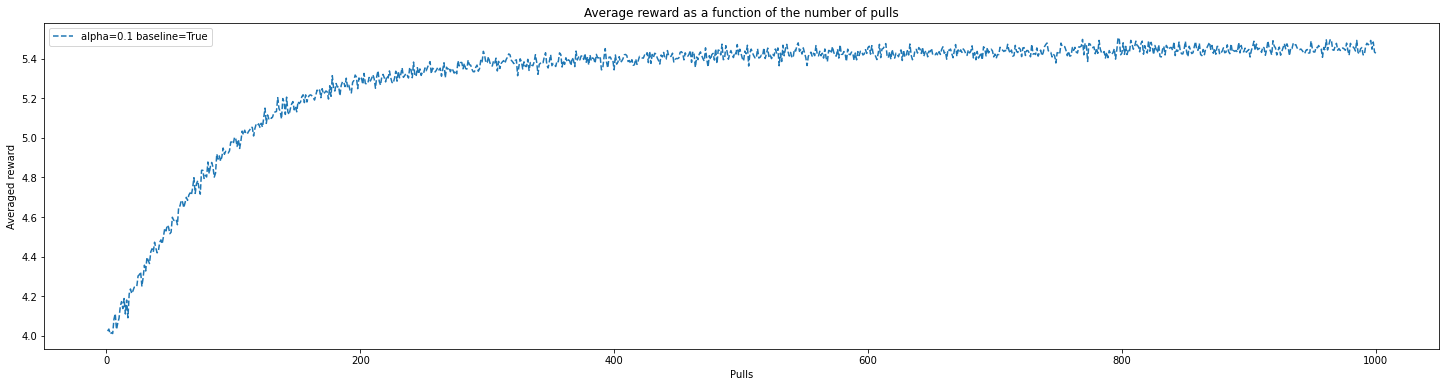

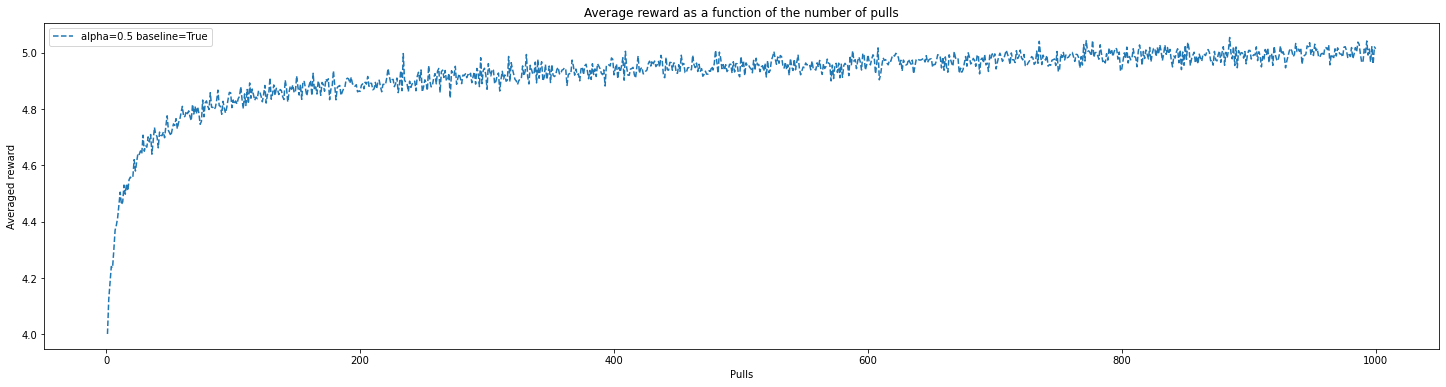

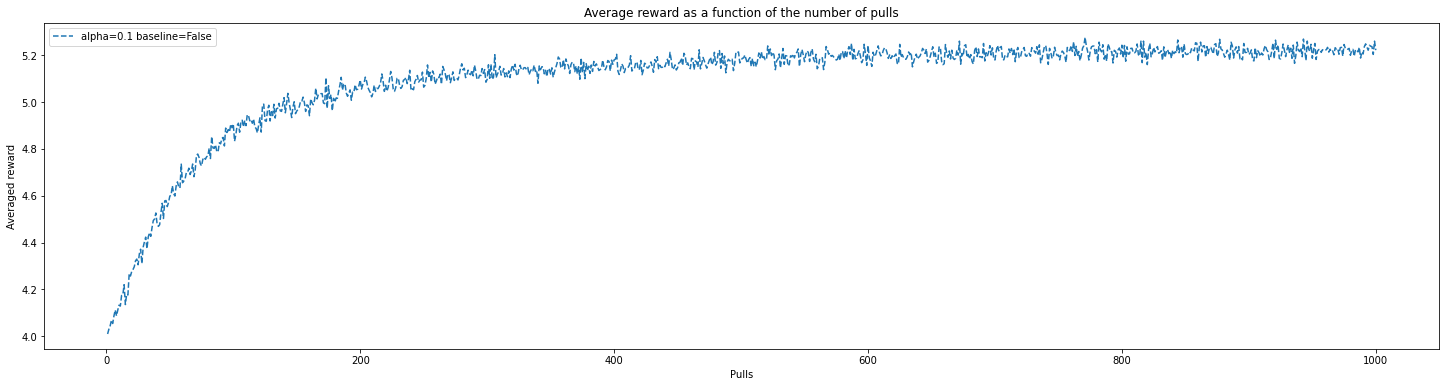

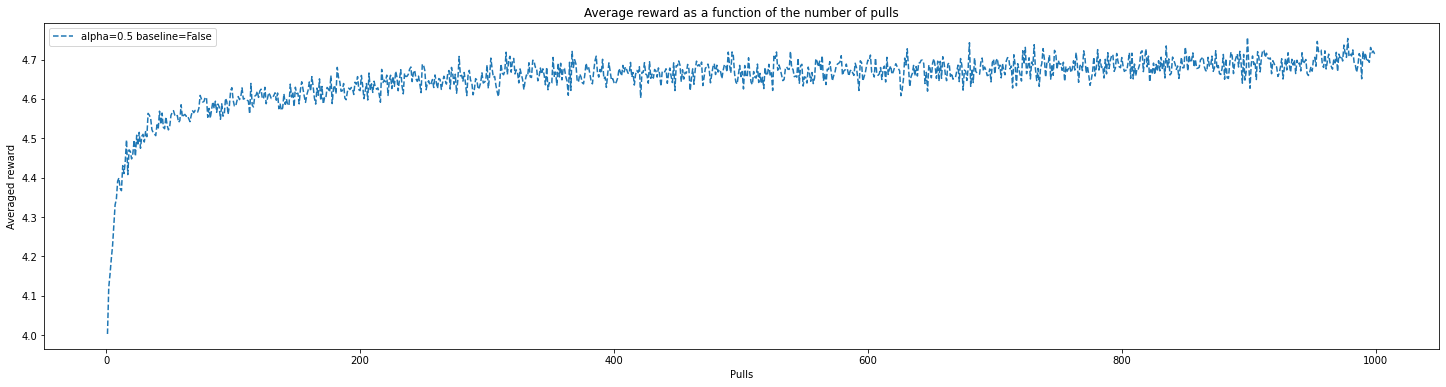

In [ ]:
plt.rcParams['figure.figsize'] = [25, 6]
Gradient_Bandit_Plots(2000, 1000, 0.1, True, meanNormal = 4)
Gradient_Bandit_Plots(2000, 1000, 0.5, True, meanNormal = 4)
Gradient_Bandit_Plots(2000, 1000, 0.1, False, meanNormal = 4)
Gradient_Bandit_Plots(2000, 1000, 0.5, False, meanNormal = 4)

Indeed we see that (alpha = 0.1 with baseline) have the best average reward, and that (alpha = 0.5 without baseline) have the worst. However (alpha = 0.1 without baseline) and (alpha = 0.5 with baseline) are pretty close.

##### Q8

First we should plot the gradient bandit with mean 0 for the distribution of the action values, to have a fair comparison with the other plots

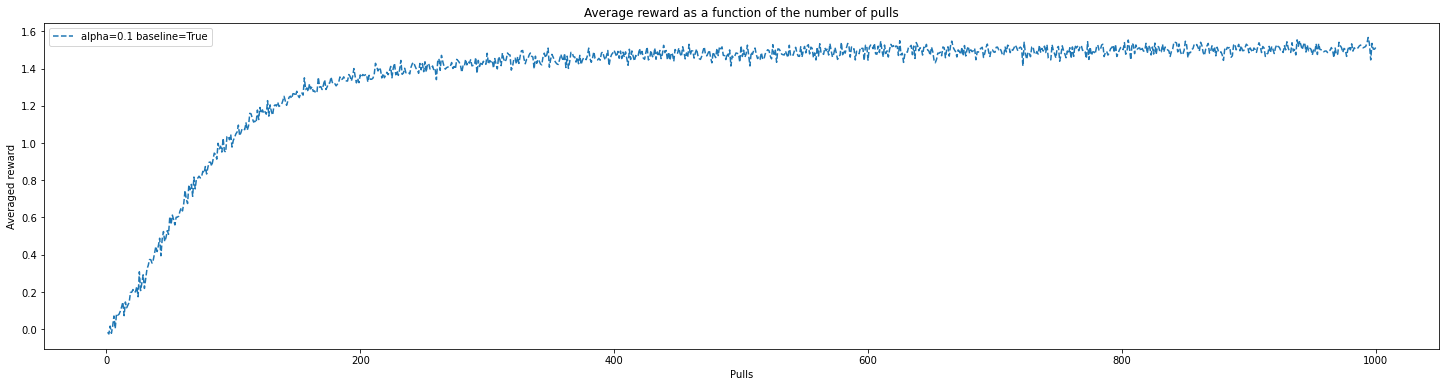

In [ ]:
Gradient_Bandit_Plots(2000, 1000, 0.1, True, meanNormal = 0)

Now we can summarize: (we take the best parameters for each method)

* **Epsilon greedy (with eps = 0.1):** goes up to avg_award = 1 in less than 20 pulls, and converges to **avg_award = 1.25**

* **Optimistic initial value (with initValue = 3):** goes up to avg_award = 1.3 in less than 20 pulls, and converges to **avg_award = 1.4**

* **UCB (with c = 1):** goes up to avg_award = 1.1 in less than 20 pulls, and converges to **avg_award = 1.5**

* **Gradient Bandit (with baseline and alpha = 0.1):** needs approx 100 pulls to go up to avg_award = 1, and converges to **avg_award = 1.55**

So in terms of the **average award** at the convergence: **Gradient Bandit > UCB > Optimistic initial value > Epsilon greedy**

But in terms of the **speed of convergence**: **Optimistic initial value > UCB > Epsilon greedy** but are all fast and almost equivalent, unlike **Gradient Bandit** which is slow.

Since **regret** is correlated to the average award, then the ranking in terms of regret is the same as the ranking in terms of average award, and is **Gradient Bandit** *better than* **UCB** *better than* **Optimistic initial value** *better than* **Epsilon greedy**


## 2 Dynamic Programming

##### Q1

Since
* Every action deterministically cause the corresponding state transition
* The agent follows the equiprobable random policy
* And we have an undiscounted, episodic task
* The reward is −1 on all transitions until the terminal state

Then $p(s', r|s, a) = 1$, $\pi (a|s) = \frac{1}{4}$, $\gamma = 1$, and $r=-1$

So the Bellman equations for the state value and the action value functions can be simplified to:

$$v_{\pi} (s) = \sum_{a=1}^{4} \frac{1}{4} \sum_{s'} (-1 + v_{\pi} (s')) = \sum_{s'} (-1 + v_{\pi} (s'))$$
$$q_{\pi} (s, a) =  -1 + v_{\pi} (s')$$

We want to solve the system 

\begin{equation}
    \begin{cases}
      v_{\pi} (0) = v_{\pi} (24) = 0\\
      v_{\pi} (s) = \sum_{s'} (-1 + v_{\pi} (s')) ~~~~ \forall s \in {1, ..., 23}
    \end{cases}\,
\end{equation}

In [ ]:
from scipy.optimize import fsolve

def myBellmanSystem(v):
  F = np.zeros(25)

  for s in range(0, 25):
    if (s == 0) or (s == 24):
      F[s] = v[s]
    elif s == 4:
      F[4] = v[4] + 4 - (v[3] + v[9] + 2*v[4])
    elif s == 20:
      F[20] = v[20] + 4 - (v[15] + v[21] + 2*v[20])
    elif s in range(1, 4):
      F[s] = v[s] + 4 - (v[s-1] + v[s+1] + v[s+5] + v[s])
    elif s in range(5, 16, 5):
      F[s] = v[s] + 4 - (v[s-5] + v[s+1] + v[s+5] + v[s])
    elif s in range(9, 20, 5):
      F[s] = v[s] + 4 - (v[s-5] + v[s-1] + v[s+5] + v[s])
    elif s in range(21, 24):
      F[s] = v[s] + 4 - (v[s-1] + v[s+1] + v[s-5] + v[s])
    else:
      F[s] = v[s] + 4 - (v[s-1] + v[s+1] + v[s-5] + v[s+5])

  return F

zeros = np.zeros(25)
state_value_function = fsolve(myBellmanSystem, zeros)

print(f"\n v_pi(16) = {np.around(state_value_function[16], 1)}")
print(f" v_pi(12) = {np.around(state_value_function[12], 1)}")

v_equiprobable_policy = np.around(state_value_function, 1).reshape(5, 5)
print(v_equiprobable_policy) # state value function for the equiprobable policy


 v_pi(16) = 0.0
 v_pi(12) = 1.3
[[ 0.  -5.4  1.3  8.   2.7]
 [ 9.4  2.7  1.3 -0.  -6.7]
 [ 1.3  1.3  1.3  1.3  1.3]
 [-6.7  0.   1.3  2.7  9.4]
 [ 2.7  8.   1.3 -5.4  0. ]]


Now that we know that $v_{\pi} (16) = 0$ and $v_{\pi} (12) = 1.3$

We can calculate:
$$q_{\pi} (11, down) =  -1 + v_{\pi} (16) = -1 + 0 = -1$$
$$q_{\pi} (7, down) =  -1 + v_{\pi} (12) = -1 + 1.3 = 0.3$$

##### Q2

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/E7RGaY4.png", width=800, height=500)
# another link: https://imgur.com/a/7776EeL

##### Q3

###### Q3-a

In [ ]:
!pip install git+https://github.com/zafarali/emdp.git

  Cloning https://github.com/zafarali/emdp.git to /tmp/pip-req-build-nt4n9dkc
  Running command git clone -q https://github.com/zafarali/emdp.git /tmp/pip-req-build-nt4n9dkc


In [384]:
import emdp.gridworld as gw
from emdp import actions
# Knowing that actions.LEFT = 0, actions.RIGHT = 1, actions.UP = 2, actions.DOWN = 3

def build_gridworld():
  size = 5
  gamma = 0.99
  terminal_states = [(0, 0), (4, 4)]

  P = gw.build_simple_grid(size, terminal_states, p_success=1)

  R = np.zeros((P.shape[0], P.shape[1]))
  R[:, :] = -1

  p0 = np.ones(P.shape[0])/P.shape[0]

  return gw.GridWorldMDP(P, R, gamma, p0, terminal_states, size)

In [385]:
def policy_evaluation(policy, state_values_entry):
  mdp = build_gridworld()
  MDPactions = [actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN] # which is equal to [0, 1, 2, 3]
  gamma = mdp.gamma

  state_values = state_values_entry.copy()

  while (True):
    state_values_old = state_values.copy()
    for s in range(1, 24):
      mdp.set_current_state_to(mdp.unflatten_state(np.eye(26)[s]))
      action = policy[s]
      state, reward, done, _ = mdp.step(int(action))
      next_s = np.where(state == 1)[0][0]
      state_values[s] = reward + gamma * state_values[next_s]

    D = abs(state_values_old - state_values).max()
    if D < 1e-4:
      break

  return state_values

In [220]:
def one_policy_improvement_round(state_values):
  mdp = build_gridworld()
  gamma = mdp.gamma
  MDPactions = [actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN]
  improvedPolicy = []

  for s in range(1, 24):
    all_pi_s = []
    for action in MDPactions:
      mdp.set_current_state_to(mdp.unflatten_state(np.eye(26)[s]))
      state, reward, done, _ = mdp.step(action)
      next_s = np.where(state == 1)[0][0]
      all_pi_s.append(reward + gamma * state_values[next_s])

    greedyAction = MDPactions[np.argmax(np.array(all_pi_s))]
    improvedPolicy.append(greedyAction)

  return np.array([0] + improvedPolicy + [0])

In [425]:
def policy_iteration():
  size = 5

  initial_random_policy = np.random.randint(low = actions.LEFT, high = actions.DOWN, size = size * size)
  initial_state_values = np.zeros(size * size)

  policy = initial_random_policy.copy()
  state_values = initial_state_values.copy()

  iterations = 0
  while True:
    policy_old = policy.copy()
    state_values = policy_evaluation(policy, state_values)
    policy = one_policy_improvement_round(state_values)
    if np.array_equal(policy, policy_old):
      break

    iterations += 1

  return policy, state_values, iterations

In [426]:
optimal_policy_policy_iteration, optimal_state_values, nIterations = policy_iteration()
print(f"Optimal policy (policy iteration):\n {optimal_policy_policy_iteration.reshape(5,5)}\n")
print(f"Optimal state values:\n {optimal_state_values}\n")
print(f"Total number of iterations: {nIterations}\n")

Optimal policy (policy iteration):
 [[0 0 0 0 0]
 [2 0 0 0 3]
 [2 0 0 1 3]
 [2 0 1 1 3]
 [1 1 1 1 0]]

Optimal state values:
 [ 0.       -1.       -1.99     -2.9701   -3.940399 -1.       -1.99
 -2.9701   -3.940399 -2.9701   -1.99     -2.9701   -3.940399 -2.9701
 -1.99     -2.9701   -3.940399 -2.9701   -1.99     -1.       -3.940399
 -2.9701   -1.99     -1.        0.      ]

Total number of iterations: 3



In [438]:
def meanReward_numberTimesteps(policy): #Q3-a
  mdp = build_gridworld()
  nEpisodes = 5
  rewards = [0]*nEpisodes
  timesteps = [0]*nEpisodes

  done = False
  for episode in range(nEpisodes):
    mdp.reset()
    state, reward, done, _ = mdp.step(int(np.random.choice([actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN], 1)[0]))
    while done == False:
      s = np.where(state == 1)[0][0]
      if s == 25:
        break
      print(policy[s])
      state, reward, done, _ = mdp.step(int(policy[s]))
      rewards[episode] += reward
      timesteps[episode] += 1
      if s == 0 or s == 24:
        break
  print({"mean reward": sum(rewards)/len(rewards), "mean timesteps": sum(timesteps)/len(timesteps)})

In [432]:
def policy_iteration_with_meanReward_numberTimesteps():
  size = 5

  initial_random_policy = np.random.randint(low = actions.LEFT, high = actions.DOWN, size = size * size)
  initial_state_values = np.zeros(size * size)

  policy = initial_random_policy.copy()
  state_values = initial_state_values.copy()

  iterations = 0
  while True:
    policy_old = policy.copy()
    state_values = policy_evaluation(policy, state_values)
    policy = one_policy_improvement_round(state_values)
    if np.array_equal(policy, policy_old):
      break

    iterations += 1
    print(f"Iteration: {iterations}")
    meanReward_numberTimesteps(policy) # function for Q3-a

  #return policy, state_values, iterations

In [436]:
#if this cell takes more than 5s, it should be re-executed more than once
policy_iteration_with_meanReward_numberTimesteps()

Iteration: 1
{'mean reward': -4.2, 'mean timesteps': 4.2}
Iteration: 2
{'mean reward': -2.6, 'mean timesteps': 2.6}
Iteration: 3
{'mean reward': -3.4, 'mean timesteps': 3.4}
Iteration: 4
{'mean reward': -2.6, 'mean timesteps': 2.6}


In [376]:
def value_iteration():
  mdp = build_gridworld()
  size = mdp.size
  gamma = mdp.gamma
  MDPactions = [actions.LEFT, actions.RIGHT, actions.UP, actions.DOWN]

  initial_random_state_values = np.random.randint(low = -10, high = 10, size = size * size)
  initial_random_state_values[0] = initial_random_state_values[24] = 0

  state_values = initial_random_state_values.copy()
  while (True):
    state_values_old = state_values.copy()
    for s in range(1, 24):
      all_v_s = []
      for action in MDPactions:
        mdp.set_current_state_to(mdp.unflatten_state(np.eye(26)[s]))
        state, reward, done, _ = mdp.step(action)
        next_s = np.where(state == 1)[0][0]
        all_v_s.append(reward + gamma * state_values[next_s])

      state_values[s] = max(all_v_s)

    D = abs(state_values_old - state_values).max()
    if D < 1e-2:
      break

  policy = one_policy_improvement_round(state_values)

  return policy

In [437]:
optimal_policy_value_iteration = value_iteration()
print(f"Value iteration's optimal policy:\n {optimal_policy_value_iteration.reshape(5,5)}\n")

Value iteration's optimal policy:
 [[0 0 0 0 0]
 [2 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 3]
 [0 0 0 1 0]]



###### Q3-b

In [361]:
def visualize_policy(policy):
  viz = []
  for i in policy:
    if i == 0:
      viz.append("LEFT")
    elif i == 1:
      viz.append("RIGHT")
    elif i == 2:
      viz.append("UP")
    else:
      viz.append("DOWN")
  viz[0] = viz[24] = "T"
  return np.array(viz).reshape(5, 5)

In [378]:
print(f"Policy iteration's optimal policy:\n {visualize_policy(optimal_policy_policy_iteration)}\n")
print(f"Value iteration's optimal policy:\n {visualize_policy(optimal_policy_value_iteration)}\n")

Policy iteration's optimal policy:
 [['T' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['UP' 'LEFT' 'LEFT' 'LEFT' 'DOWN']
 ['UP' 'LEFT' 'LEFT' 'RIGHT' 'DOWN']
 ['UP' 'LEFT' 'RIGHT' 'RIGHT' 'DOWN']
 ['RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'T']]

Value iteration's optimal policy:
 [['T' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['UP' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'LEFT']
 ['LEFT' 'LEFT' 'LEFT' 'LEFT' 'DOWN']
 ['LEFT' 'LEFT' 'LEFT' 'RIGHT' 'T']]



We observe that the optimal policy obtained by policy iteration is the same as the optimal policy I expected in Q2. The optimal policy obtained by value iteration is only close to it next to the terminal states.